# **NYC Air Quality Predictive Modeling**


NYC Air Quality

## NYC Air Quality:
The air quality data we are looking at contains hourly PM2.5 measurements across 25 stations over 2024. PM2.5 refers to particulate matter with a diameter of $2.5\mu m$ (micrometers) or less, which poses significant health risks due to its ability to penetrate deep into the lungs and enter the bloodstream. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import glob
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib as plt

### Data Cleaning 

In [2]:
def combine_and_clean_data(folder_path, threshold, lags=4):

    # grab files
    files = glob.glob(folder_path + "/*.csv")

    # combine into df
    df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

    # change time and site variables for analysis
    df['ObservationTimeUTC'] = pd.to_datetime(df['ObservationTimeUTC'], errors='coerce')

    # grab labels and add them with merge
    labels = pd.read_csv("data/AQ_2024/labels.csv")
    df = df.merge(labels, on="SiteID", how="left")
    df = df.drop(columns=['SiteName_x'])
    df = df.drop(columns=['SiteID'])
    df = df.rename(columns={'SiteName_y': 'SiteName'})
    
    # build lag features + target T/F
    def add_lags_and_target(g):
        for i in range(1, lags):
            g[f'lag_{i}'] = g['Value'].shift(i)
        g['target'] = (g['Value'] > threshold).astype('Int64')
        return g

    df = df.groupby('SiteName', group_keys=False).apply(add_lags_and_target)

    # drop incomplete rows
    lag_cols = [f'lag_{i}' for i in range(1, lags)]
    df = df.dropna(subset=lag_cols + ['target'])

    # stats across all lag columns
    df['lag_mean']   = df[lag_cols].mean(axis=1)
    df['lag_std']    = df[lag_cols].std(axis=1)
    df['lag_median'] = df[lag_cols].median(axis=1)

    return df

In [3]:
def temporal_train_test_split(df, test_size=0.2, time_col='ObservationTimeUTC'):
    """
    Split by time: the earliest (1 - test_size) fraction is train, 
    the latest fraction is test. Prevents future→past leakage.
    """
    df = df.sort_values(time_col).reset_index(drop=True)
    cutoff_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:cutoff_idx].copy()
    test_df  = df.iloc[cutoff_idx:].copy()
    return train_df, test_df


def build_rf_pipeline(lag_cols=None, n_estimators=400, random_state=42, lags=4):
    """
    Random Forest pipeline using ONLY lag features (no SiteName).
    """
    # If lag_cols not given, create lag_1..lag_l
    if lag_cols is None:
        lag_cols = [f'lag_{i}' for i in range(1, lags + 1)]

    numeric_features = lag_cols

    preproc = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
        ],
        remainder="drop"
    )

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        class_weight="balanced",
        random_state=random_state
    )

    model = Pipeline(steps=[("prep", preproc), ("rf", rf)])
    return model, numeric_features


def build_log_pipeline(lag_cols=None, random_state=42, lags=4):
    """
    Logistic Regression pipeline using ONLY lag features (no SiteName).
    """
    if lag_cols is None:
        lag_cols = [f'lag_{i}' for i in range(1, lags + 1)]

    numeric_features = lag_cols

    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features)
        ],
        remainder="drop"
    )

    log_reg = LogisticRegression(
        max_iter=500,
        class_weight='balanced',   # good for imbalanced data
        solver='lbfgs',
        random_state=random_state
    )

    model = Pipeline(steps=[
        ("prep", preprocess),
        ("log_reg", log_reg)
    ])
    
    return model


def train_and_evaluate(df, model_type="rf", test_size=0.2, threshold=0.5, roc=False, lags=4):
    """
    df must contain columns: 
      'ObservationTimeUTC', lag_1..lag_k, 'target'
    (SiteName can be present but is NOT used as a feature.)
    """
    # 1) temporal split
    train_df, test_df = temporal_train_test_split(
        df, test_size=test_size, time_col='ObservationTimeUTC'
    )

    # features = all lag_* columns ONLY
    lag_cols = [c for c in df.columns if c.startswith("lag_")]
    feature_cols = lag_cols

    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_test  = test_df[feature_cols]
    y_test  = test_df['target']

    # 2) build model
    if model_type == "log":
        model = build_log_pipeline(lag_cols=lag_cols, lags=lags)
        model_name = "Logistic Regression"
    else:
        model, _ = build_rf_pipeline(lag_cols=lag_cols, lags=lags)
        model_name = "Random Forest"
    
    # 3) fit
    model.fit(X_train, y_train)

    # 4) probabilities and predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    # 5) ROC curve
    if roc:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({model_name})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 6) metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # 7) print results
    print(f"=== {model_name} (time-aware split) ===")
    print(f"Threshold used for target: {threshold}")
    print(f"Train size: {len(train_df):,}  |  Test size: {len(test_df):,}")
    print(f"Accuracy : {acc:0.4f}")
    print(f"Precision: {prec:0.4f}")
    print(f"Recall   : {rec:0.4f}")
    print(f"F1-score : {f1:0.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report")
    print(classification_report(y_test, y_pred, digits=4))

    return model, (X_train, y_train, X_test, y_test)


In [4]:
folder_path = "data/AQ_2024"

# PM 2.5 value we want to predict on
threshold = 15

# number of past values in looks at + 1
# if we want to look at past 3 values num_lags=4
num_lags = 6
df = combine_and_clean_data(folder_path, threshold, num_lags)
df.shape
df.head()


C:\Users\edcro\AppData\Local\Temp\ipykernel_9800\487870204.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('SiteName', group_keys=False).apply(add_lags_and_target)


,ID,ObservationTimeUTC,Value,Latitude_x,Longitude_x,SiteName,Latitude_y,Longitude_y,lag_1,lag_2,lag_3,lag_4,lag_5,target,lag_mean,lag_std,lag_median
95,544421.0,2024-04-01 05:00:00,6.29,NaN,NaN,Queensboro Bridge,40.76123,-73.96389,6.72,6.89,6.78,6.85,6.89,0,6.826,0.074364,6.85
96,535984.0,2024-04-01 05:00:00,5.49,NaN,NaN,Queens College,40.73711,-73.82156,5.28,4.89,5.45,5.90,5.61,0,5.426,0.376736,5.45
97,544422.0,2024-04-01 05:00:00,6.19,NaN,NaN,Cross Bronx Expy,40.84517,-73.90614,6.49,7.12,7.28,7.27,7.69,0,7.170,0.435144,7.27
98,535985.0,2024-04-01 05:00:00,5.37,NaN,NaN,Broadway/35th St,40.75069,-73.98783,5.48,6.58,6.56,7.35,7.60,0,6.714,0.829747,6.58
99,535986.0,2024-04-01 05:00:00,6.68,NaN,NaN,FDR,40.72229,-73.97465,6.85,6.75,7.26,7.68,7.88,0,7.284,0.496518,7.26


## Air Quality Classification Model 1: Random Forest

In [5]:
model, (X_train, y_train, X_test, y_test) = train_and_evaluate(df, test_size=0.2, threshold=0.4)

=== Random Forest (time-aware split) ===
Threshold used for target: 0.4
Train size: 64,057  |  Test size: 16,015
Accuracy : 0.9738
Precision: 0.7258
Recall   : 0.6862
F1-score : 0.7055
Confusion Matrix:
[[15092   190]
 [  230   503]]

Classification Report
              precision    recall  f1-score   support

         0.0     0.9850    0.9876    0.9863     15282
         1.0     0.7258    0.6862    0.7055       733

    accuracy                         0.9738     16015
   macro avg     0.8554    0.8369    0.8459     16015
weighted avg     0.9731    0.9738    0.9734     16015



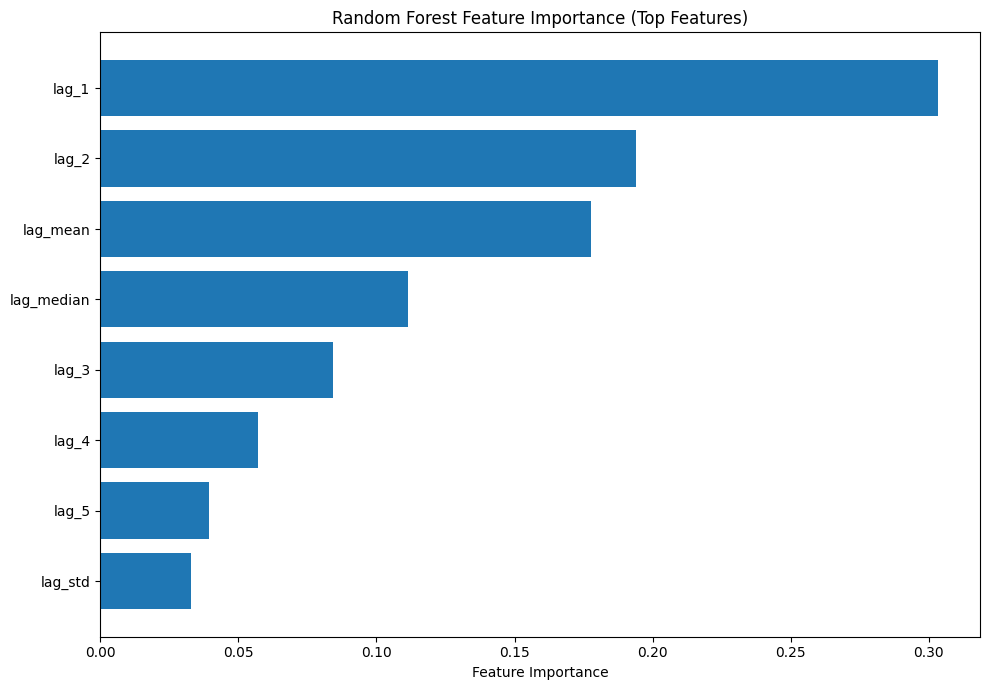

In [6]:
import matplotlib.pyplot as plt

feature_cols = X_train.columns
top_n=20

# Extract the RandomForest model
rf = model.named_steps['rf']

# Since no OneHotEncoder is used now, feature_cols = lag_1 ... lag_k
all_features = np.array(feature_cols)

# Importances from RF
importances = rf.feature_importances_

# Sort top N
idx = np.argsort(importances)[::-1][:top_n]
sorted_features = all_features[idx]
sorted_importances = importances[idx]

plt.figure(figsize=(10, 7))
plt.barh(sorted_features[::-1], sorted_importances[::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Top Features)")
plt.tight_layout()
plt.show()

In [7]:
from sklearn.tree import plot_tree
tree_index=0
max_depth=4

rf = model.named_steps['rf']
estimator = rf.estimators_[tree_index]

plt.figure(figsize=(150, 70))
plot_tree(estimator, filled=True, max_depth=max_depth)
plt.show()

In [8]:
import joblib

joblib.dump(model, "./air_quality_rf.joblib")

['./air_quality_rf.joblib']

## Air Quality Classification Model 2: Logistic Classification

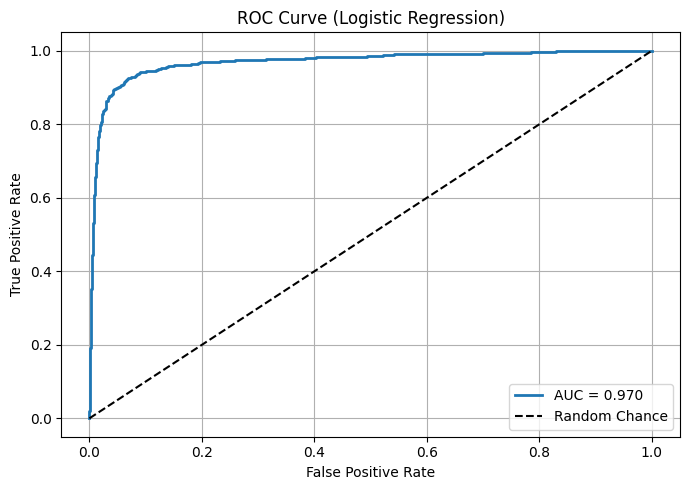

=== Logistic Regression (time-aware split) ===
Threshold used for target: 0.4
Train size: 64,057  |  Test size: 16,015
Accuracy : 0.9544
Precision: 0.5012
Recall   : 0.8854
F1-score : 0.6400
Confusion Matrix:
[[14636   646]
 [   84   649]]

Classification Report
              precision    recall  f1-score   support

         0.0     0.9943    0.9577    0.9757     15282
         1.0     0.5012    0.8854    0.6400       733

    accuracy                         0.9544     16015
   macro avg     0.7477    0.9216    0.8079     16015
weighted avg     0.9717    0.9544    0.9603     16015



In [9]:
model, (X_train, y_train, X_test, y_test) = train_and_evaluate(df, model_type="log", test_size=0.2, roc=True, threshold=0.4, lags=num_lags)

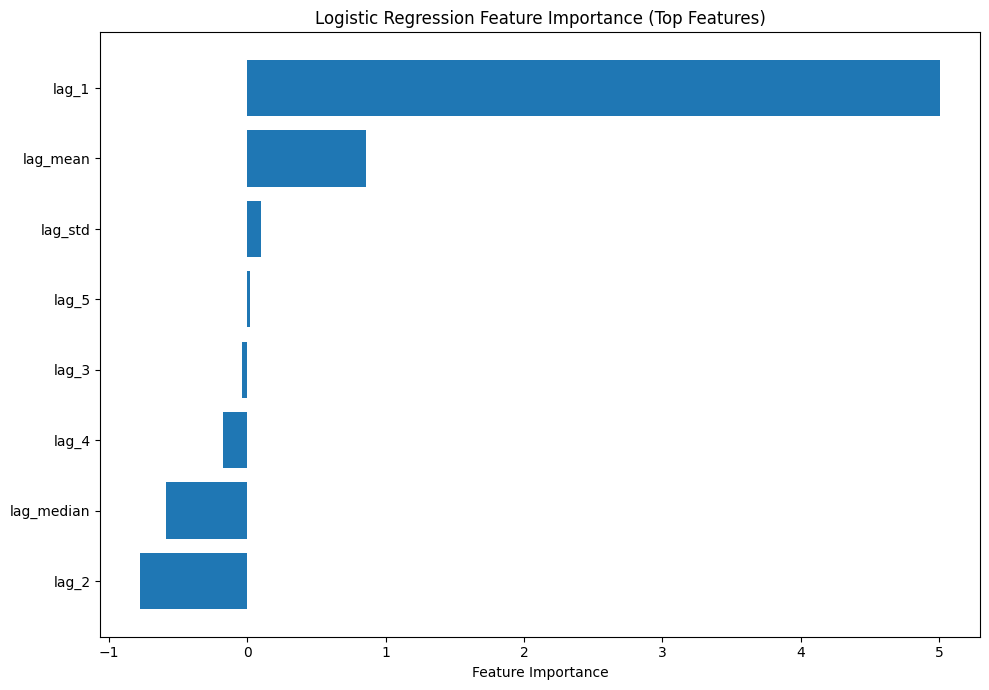

In [10]:
import matplotlib.pyplot as plt

feature_cols = X_train.columns
top_n=20

# Extract the RandomForest model
rf = model.named_steps['log_reg']

# Since no OneHotEncoder is used now, feature_cols = lag_1 ... lag_k
all_features = np.array(feature_cols)

# Importances from RF
importances = rf.coef_[0]

# Sort top N
idx = np.argsort(importances)[::-1][:top_n]
sorted_features = all_features[idx]
sorted_importances = importances[idx]

plt.figure(figsize=(10, 7))
plt.barh(sorted_features[::-1], sorted_importances[::-1])
plt.xlabel("Feature Importance")
plt.title("Logistic Regression Feature Importance (Top Features)")
plt.tight_layout()
plt.show()